# Laboratory #07 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

# **Students** (First Name and Last Name)

1.   Oriol Miró
2.   Marc Gonzalez

---

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq

from matplotlib import pyplot as plt

# extras
from tqdm import tqdm # i like checking progress! lot's of images
from sklearn.model_selection import train_test_split # because as we loaded the data it is ordered! (first 1/3 first label, second 1/3 second label, ...)
from sklearn.cluster import MiniBatchKMeans # asked for in an exercise

# Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment.
The subset of images is provided along with the notebook.
Upload the dataset to the drive and mount it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# modify the dataset variable with the path from your drive

dataset_path = r'/content/drive/MyDrive/MAI_CV_LAB/labs_6_7/Caltech_101_subset'

In [ ]:
categories = ['butterfly', 'kangaroo', 'dalmatian']

*   Create a list of file and the corresponding labels

In [ ]:
# solution
data = []
for category_index, category in enumerate(tqdm(categories, desc="Processing categories")):
    category_path = os.path.join(dataset_path, category)
    for filename in tqdm(os.listdir(category_path), desc=f"Processing files in {category}", leave=False):
        if filename.endswith('.jpg'):
            file_path = os.path.join(category_path, filename)

            image = imread(file_path, as_gray=True) # because ORB requires it so
            data.append((image, category_index))

Processing categories: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


In [ ]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [ ]:
# solution

X = [item[0] for item in data] # features
y = [item[1] for item in data] # labels

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


In [ ]:
print(f"x_train[0].shape: {x_train[0].shape}")
print(f"x_test[0].shape: {x_test[0].shape}")

x_train[0].shape: (300, 242)
x_test[0].shape: (225, 300)


*   How do you select the train/test split?

**Solution**

Given data is originally ordered on the `data` variable (because we loaded classes sequentially) we must shuffle the data. To do so, we employ the function `train_test_split` from `sklearn`, parametrized as instructed with a train size of 90% and a test size of 10%; this function shuffles the data ensuring we get, on average, a fair representation of each class's importance to the dataset on the train and the test. Moreover we set a seed for reproducibility of our results.

# Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [ ]:
# solution
orb_detector = ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.


In [ ]:
# solution
train_descriptors = []

for image in tqdm(x_train, desc="Extracting ORB descriptors"):
    orb_detector.detect_and_extract(image)
    descriptors = orb_detector.descriptors
    train_descriptors.append(descriptors)

Extracting ORB descriptors: 100%|██████████| 219/219 [01:09<00:00,  3.14it/s]


*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [ ]:
# solution

print(f"Shape of the first descriptor set: {train_descriptors[0].shape}")
print(f"\nSize of each feature descriptor: {train_descriptors[0].shape[1]}")
print(f"\Example of a feature descriptor: {train_descriptors[0][0]}")


Shape of the first descriptor set: (64, 256)

Size of each feature descriptor: 256
\Example of a feature descriptor: [False False  True  True False  True  True False  True  True False False
 False  True  True False  True False  True False  True  True  True  True
  True False  True  True False False  True False  True False  True  True
 False  True  True False  True  True  True  True  True False False False
 False  True  True False  True  True False  True False  True False  True
  True False  True False False False  True  True False  True False  True
 False  True  True False False False False  True  True False False False
  True False  True False  True False  True  True False False  True  True
 False False False False False  True False  True False False False  True
 False  True False False  True  True  True False  True False False False
 False  True False  True False False False False False  True  True  True
 False False False  True  True False False False False  True  True  True
 False 

**Solution**

Each image has 64 descriptors, and each descriptor has 256 dimensions. Each dimension represents a binary string, where each bit encodes the result of an intensity comparison between two predefined pixels within a patch around a detected keypoint. The pixel pairs are chosen randomly during descriptor generation but remain consistent for all keypoints.

# Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use [sklearn.cluster.MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) for K-Means

In [ ]:
# solution

number_of_classes = len(categories)
k = number_of_classes * 10

# combine into a single array
all_descriptors = np.vstack(train_descriptors)

# fit kmeans
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=100000) # i found higher batch size worked better!
kmeans.fit(all_descriptors)

codebook = kmeans.cluster_centers_
print(f"Codebook shape: {codebook.shape}")

Codebook shape: (30, 256)


*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [ ]:
# solution

x_train_histograms = []
for descriptors in tqdm(train_descriptors, desc="Generating image histograms"):
    # assign descriptors to clusters
    cluster_assignments, _ = vq(descriptors, codebook)

    # create histogram
    histogram, _ = np.histogram(cluster_assignments, bins=np.arange(k + 1))
    x_train_histograms.append(histogram)

x_train_histograms = np.array(x_train_histograms)

Generating image histograms: 100%|██████████| 219/219 [00:00<00:00, 3232.79it/s]


In [ ]:
print(f"x_train_histograms.shape: {x_train_histograms.shape}")

x_train_histograms.shape: (219, 60)


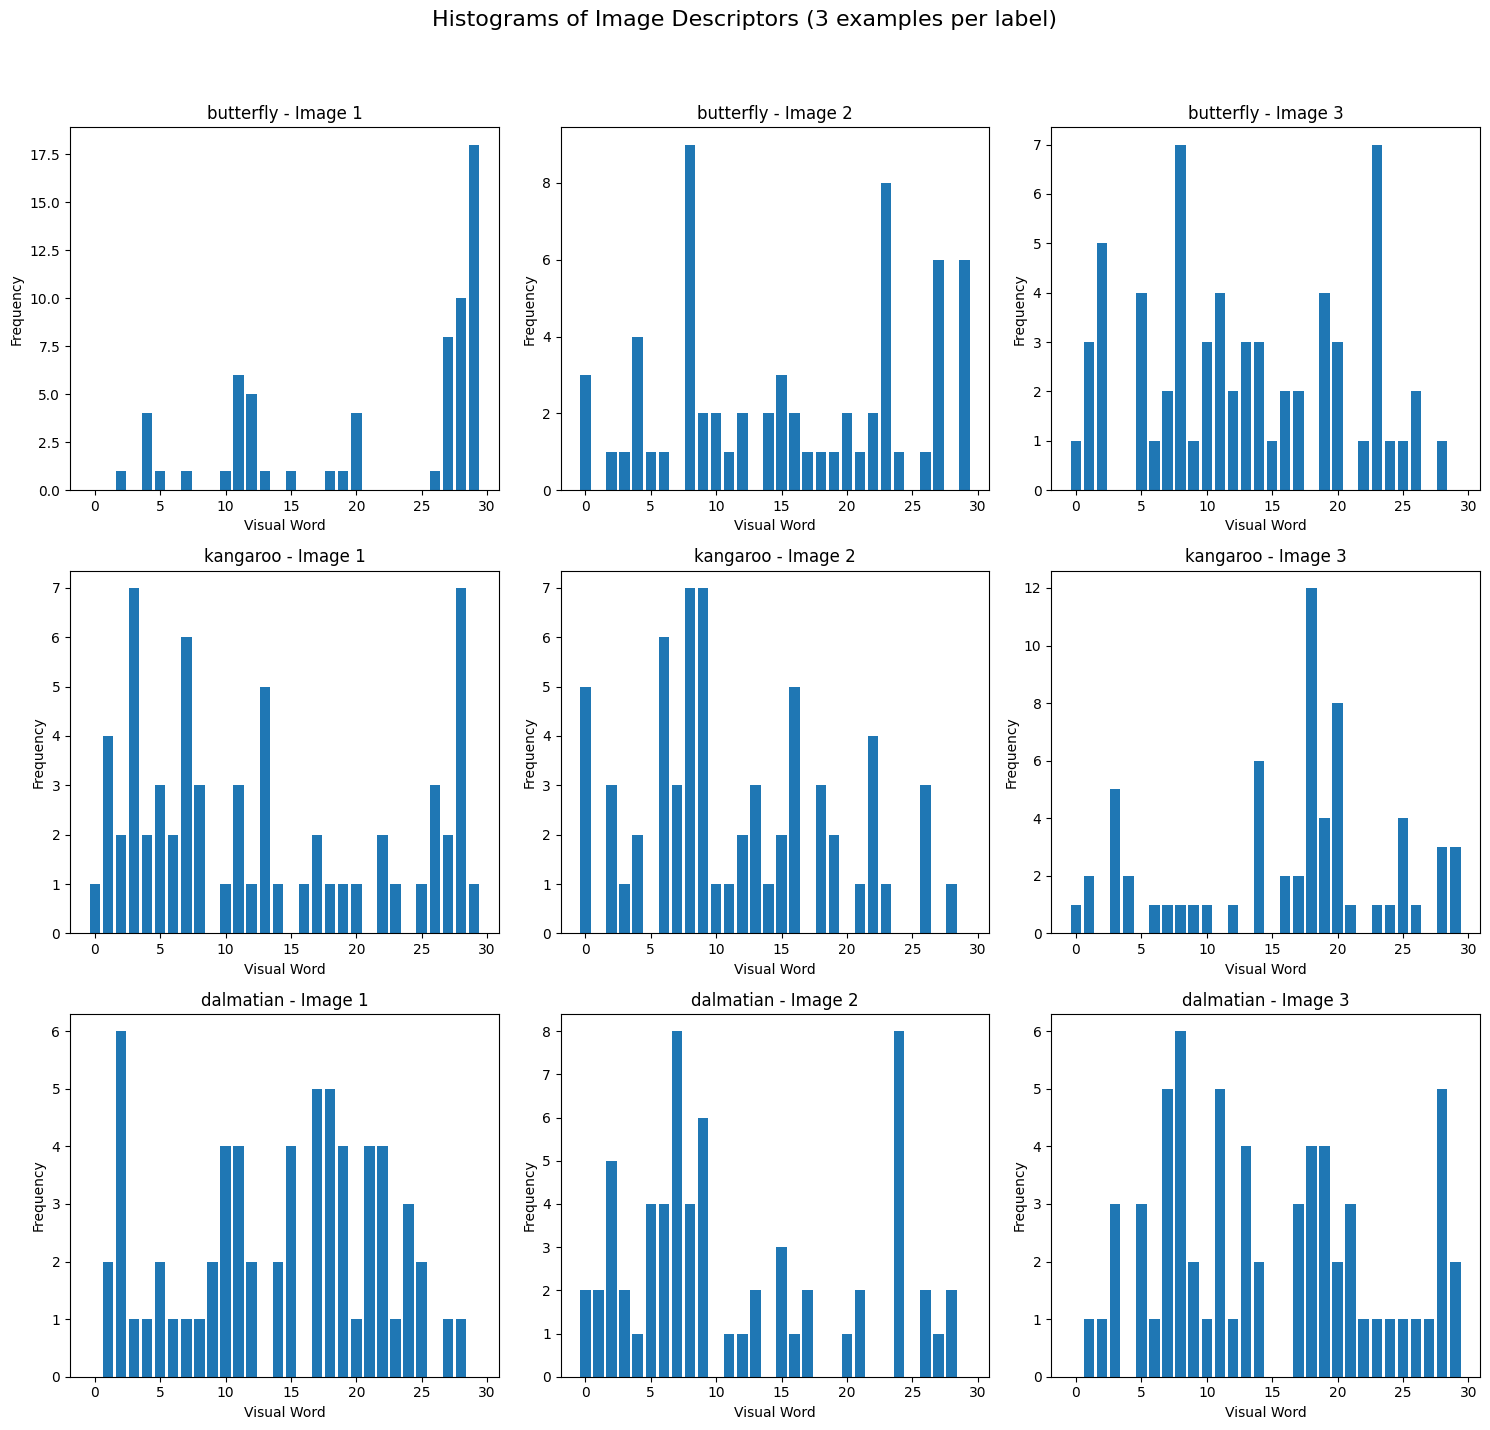

In [ ]:
# here we want to visualize some examples!

def plot_histograms(histograms, labels, category_names):
    num_categories          = len(category_names)
    num_images_per_category = 3

    fig, axes = plt.subplots(num_categories, num_images_per_category, figsize=(15, 15))
    fig.suptitle("Histograms of Image Descriptors (3 examples per label)", fontsize=16)

    for i, category in enumerate(category_names):
        category_indices = [j for j, label in enumerate(labels) if label == i]
        selected_indices = category_indices[:num_images_per_category]
        for j, index in enumerate(selected_indices):
            ax = axes[i, j]
            ax.bar(range(len(histograms[index])), histograms[index])
            ax.set_title(f"{category} - Image {j+1}")
            ax.set_xlabel("Visual Word")
            ax.set_ylabel("Frequency")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_histograms(x_train_histograms, y_train, categories)


# Creating Classification Model

*   The next step is to create a classification model. We will use a [C-Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for creating the model.



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the optimal value of C and Gamma.

In [ ]:
# solution

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    }

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train_histograms, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
best_svc = grid_search.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:
{'C': 1, 'gamma': 0.001}


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [ ]:
# solution

test_descriptors = []
for image in tqdm(x_test, desc="Extracting ORB descriptors from test images"):
    orb_detector.detect_and_extract(image)
    descriptors = orb_detector.descriptors
    test_descriptors.append(descriptors)

x_test_histograms = []
for descriptors in tqdm(test_descriptors, desc="Generating test image histograms"):
    cluster_assignments, _ = vq(descriptors, codebook)
    histogram, _ = np.histogram(cluster_assignments, bins=np.arange(k + 1))
    x_test_histograms.append(histogram)

x_test_histograms = np.array(x_test_histograms)

y_pred = best_svc.predict(x_test_histograms)



Generating test image histograms: 100%|██████████| 25/25 [00:00<00:00, 1747.54it/s]


*   Calculate the accuracy score for the classification model

In [ ]:
# solution

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.68


*   Generate the confusion matrix for the classification model

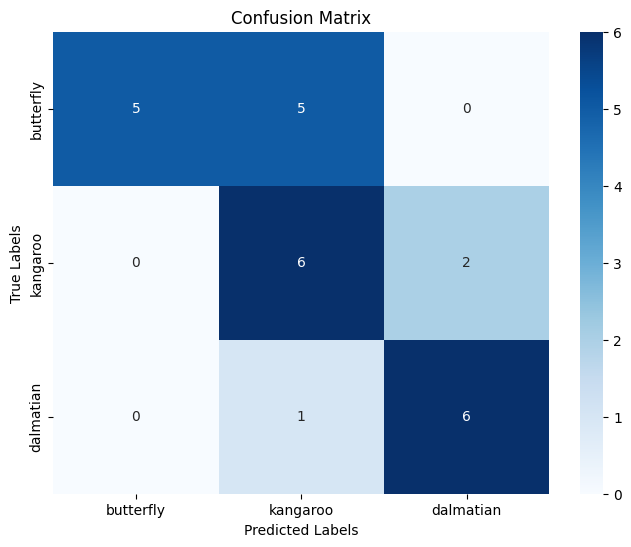

In [ ]:
# solution

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

# pretty plot with sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

*   Why do we use Clustering to create the codebook?
*   What are the other techniques that can be used to create the codebook?

**Solution**

**Question 1:**
We use clustering to create the codebook because it effectively groups similar feature descriptors extracted from images into representative clusters, known as codewords. This process reduces the high-dimensional and vast set of local descriptors into a manageable and meaningful vocabulary of visual words.

**Question 2:**
Other methods (other than K-means as we used) include Gaussian Mixture Models (to understand the distribution of features), hierarchical clustering methods, or supervised techniques like Random Forests; moreover, methods like sparse coding or deep learning techniques such as autoencoders can learn more adaptive and discriminative codebooks directly from the data, altough at a much higher computational cost.

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

Generating image histograms (256): 100%|██████████| 219/219 [00:00<00:00, 1255.25it/s]


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found (256):
{'C': 1, 'gamma': 0.001}


Generating test image histograms (256): 100%|██████████| 25/25 [00:00<00:00, 999.73it/s]


Accuracy (256 keypoints): 0.56


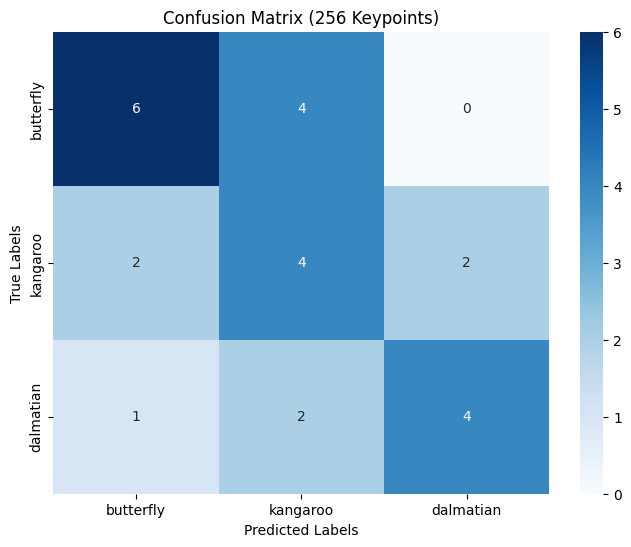

In [ ]:
# solution

# orb with 256 predictors
orb_detector_256 = ORB(n_keypoints=256)



# feature extraction
train_descriptors_256 = []
for image in tqdm(x_train, desc="Extracting 256 ORB descriptors"):
    orb_detector_256.detect_and_extract(image)
    descriptors = orb_detector_256.descriptors
    train_descriptors_256.append(descriptors)



# codebook construction
all_descriptors_256 = np.vstack(train_descriptors_256)
kmeans_256 = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=100000)
kmeans_256.fit(all_descriptors_256)
codebook_256 = kmeans_256.cluster_centers_

x_train_histograms_256 = []
for descriptors in tqdm(train_descriptors_256, desc="Generating image histograms (256)"):
    cluster_assignments, _ = vq(descriptors, codebook_256)
    histogram, _ = np.histogram(cluster_assignments, bins=np.arange(k + 1))
    x_train_histograms_256.append(histogram)
x_train_histograms_256 = np.array(x_train_histograms_256)



# train classifier
grid_search_256 = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search_256.fit(x_train_histograms_256, y_train)
print("Best parameters found (256):")
print(grid_search_256.best_params_)
best_svc_256 = grid_search_256.best_estimator_



# testing
test_descriptors_256 = []
for image in tqdm(x_test, desc="Extracting 256 ORB descriptors from test images"):
    orb_detector_256.detect_and_extract(image)
    descriptors = orb_detector_256.descriptors
    test_descriptors_256.append(descriptors)

x_test_histograms_256 = []
for descriptors in tqdm(test_descriptors_256, desc="Generating test image histograms (256)"):
    cluster_assignments, _ = vq(descriptors, codebook_256)
    histogram, _ = np.histogram(cluster_assignments, bins=np.arange(k + 1))
    x_test_histograms_256.append(histogram)
x_test_histograms_256 = np.array(x_test_histograms_256)

y_pred_256 = best_svc_256.predict(x_test_histograms_256)



# evaluation
accuracy_256 = accuracy_score(y_test, y_pred_256)
print(f"Accuracy (256 keypoints): {accuracy_256}")

conf_matrix_256 = confusion_matrix(y_test, y_pred_256)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_256, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (256 Keypoints)")
plt.show()

*   What is the difference in classifier performance between using 64 keypoints and 256 keypoints?

**Solution**

Using 64 keypoints, the classifier achieved an accuracy of **68%**, whereas with 256 keypoints, the accuracy dropped to **56%**. The confusion matrices show that with 64 keypoints, the model correctly classified more instances across all classes compared to using 256 keypoints, where misclassifications increased.

The decrease in performance suggests that adding more keypoints introduced redundancy and possibly noise, leading to us not being able to select features as good for the codebook. Additionally, since the codebook size remained constant at 30 features, it may not have been sufficient to capture the more complex feature space of 256 keypoints effectively. Therefore, using a smaller number of more distinctive keypoints (64) provided better classifier performance than using a larger number (256)

*   Will further adding more keypoints increase the performance of the algorithm?

**Solution**

Given that increasing the number of keypoints from 64 to 256 led to a decrease in performance—from 68% accuracy down to 56%—further adding more keypoints is unlikely to enhance the algorithm's performance and may actually worsen it. As we previously discussed, this seemed to introduce redundancy and noise, and makes it trickier for the most representative features to be selected for the codebook.


---

# **End of P7: Image Classification using Bag of Visual Words**

This notebook is part of **Deliverable 3**

Deadline for Deliverable 3 (P6 and P7) submission in CampusVirtual is: **Monday, the 18th of November, 2024**
